In [4]:
import numpy as np
from statsmodels.regression.linear_model import OLS

def sievebootstrap_res(data, nboot=1000):
    if isinstance(data, dict):
        # Handle the case where 'data' is a result structure
        res = data
        nboot = res['nboot']
        rng = np.random.RandomState()
        rng.set_state(res['seed'])
        meandata = np.mean(res['data'])
        data_centered = res['data'] - meandata
        order = len(res['ARcoefs'])
        ndata = len(res['data'])
        residuals_scaled = res['residuals']
    else:
        # Process the input data
        res = {}
        res['nboot'] = nboot
        res['data'] = np.array(data).copy()
        meandata = np.mean(res['data'])
        data_centered = res['data'] - meandata
        maxlags = 10
        tbl = lagtable(data_centered, maxlags)
        
        # Find the best AR order using AIC
        best_aic = np.inf
        best_order = 1
        best_model = None
        aic = np.zeros(maxlags)
        
        for order in range(1, maxlags + 1):
            X = tbl[:, :order]
            y = tbl[:, -1]
            mask = ~np.isnan(X).any(axis=1)
            X_clean = X[mask]
            y_clean = y[mask]
            
            if X_clean.size == 0:
                continue
            
            model = OLS(y_clean, X_clean).fit()
            current_aic = model.aic
            aic[order-1] = current_aic
            
            if current_aic < best_aic:
                best_aic = current_aic
                best_order = order
                best_model = model
        
        res['order'] = best_order
        res['ARcoefs'] = best_model.params[::-1].copy()  # Reverse coefficients
        
        # Compute residuals
        order = best_order
        residuals = np.full(len(data_centered), np.nan)
        for i in range(order, len(data_centered)):
            ar_input = data_centered[i - order:i]
            predicted = np.dot(res['ARcoefs'], ar_input)
            residuals[i] = predicted - data_centered[i]
        
        residuals = residuals[order:]
        residuals_scaled = np.mean(residuals) - residuals
        res['residuals'] = residuals_scaled
        
        # Save random seed state
        rng = np.random.RandomState()
        res['seed'] = rng.get_state()
        ndata = len(data_centered)
    
    # Generate bootstrap samples
    n_res = len(residuals_scaled)
    order = res['order']
    bootsets = np.zeros((ndata + 1000, nboot))
    bootsets[:order, :] = data_centered[0]  # Initialize with the first data point
    
    for i in range(order, ndata + 1000):
        prev_data = bootsets[i - order:i, :]
        ar_pred = np.dot(res['ARcoefs'], prev_data)
        indices = rng.randint(0, n_res, size=nboot)
        residual_samples = residuals_scaled[indices]
        bootsets[i, :] = residual_samples
    
    bootsets = bootsets[1000: ndata + 1000, :] + meandata
    return bootsets, res

def lagtable(data, maxlags):
    n = len(data)
    table = np.full((n, maxlags + 1), np.nan)
    for lag in range(1, maxlags + 1):
        start = lag
        end = n - lag
        table[start:, lag-1] = data[:end]
    table[:, -1] = data
    return table

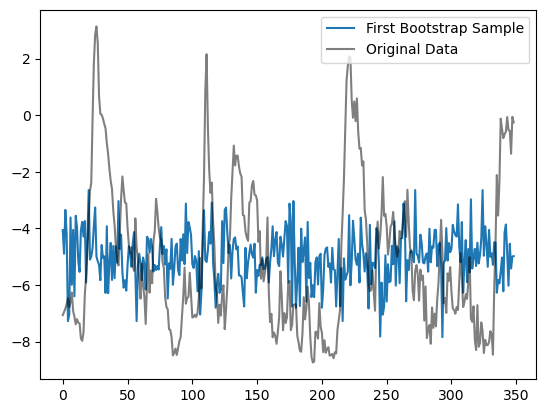

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

df_AT = pd.read_csv(r"D:\VScode\van2015_repeat\VOSTOK_data\AT.csv")
df_CO2 = pd.read_csv(r"D:\VScode\van2015_repeat\VOSTOK_data\CO2.csv")
AT = df_AT['AT'].values[50:]  # Assuming 'AT' column
CO2 = df_CO2['CO2'].values[50:]  # Assuming 'CO2' column
AT_boot, _ = sievebootstrap_res(AT, 10)
CO2_boot, _ = sievebootstrap_res(CO2, 10)

# Plotting the first bootstrap sample
plt.figure()
plt.plot(AT_boot[:, 0], label='First Bootstrap Sample')
plt.plot(AT, label='Original Data', color='black', alpha=0.5)
plt.legend()
plt.show()

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from scipy.ndimage import gaussian_filter1d
from pyEDM import CCM


def analyze_causality(var1_file, var1_col, var2_file, var2_col, 
                     var1_name='AT', var2_name='CO2', 
                     start_index=49, p=1, E=4, tau=-2, 
                     N_boots=10, Tp_range=(-10, 10)):
    # Load data
    df_var1 = pd.read_csv(var1_file)
    df_var2 = pd.read_csv(var2_file)
    
    var1 = df_var1[var1_col].values[start_index:]
    var2 = df_var2[var2_col].values[start_index:]

    # Fit AR models
    def fit_ar_model(series, p):
        model = AutoReg(series, lags=p, old_names=False)
        return model.fit().predict(start=p, end=len(series)-1)

    fitted_var1 = fit_ar_model(var1, p)
    fitted_var2 = fit_ar_model(var2, p)

    # Plot AR fits
    fig, ax = plt.subplots(2, 1, figsize=(12, 8))
    ax[0].plot(var1, label=f'Original {var1_name}')
    ax[0].plot(fitted_var1, 'r', label=f'Fitted {var1_name}')
    ax[0].set_title(f'AR Model Fit: {var1_name} Data')
    ax[0].legend()

    ax[1].plot(var2, label=f'Original {var2_name}')
    ax[1].plot(fitted_var2, 'r', label=f'Fitted {var2_name}')
    ax[1].set_title(f'AR Model Fit: {var2_name} Data')
    ax[1].legend()
    plt.tight_layout()

    # Bootstrap and analysis
    var1_boot, _ = sievebootstrap_res(var1, N_boots)
    var2_boot, _ = sievebootstrap_res(var2, N_boots)
    
    var1_boot = var1_boot[p:,:] + fitted_var1[:, None]
    var2_boot = var2_boot[p:,:] + fitted_var2[:, None]

    # Initialize result storage
    Tp_values = np.arange(*Tp_range)
    n = len(var1_boot)
    time = np.arange(1, n + 1)
    
    max_rho_var1xmapvar2 = np.zeros((len(Tp_values), N_boots))
    max_rho_var2xmapvar1 = np.zeros_like(max_rho_var1xmapvar2)
    Tp_results_var1 = np.zeros(N_boots)
    Tp_results_var2 = np.zeros(N_boots)

    # Main analysis loop
    for j in range(N_boots):
        df = pd.DataFrame({
            "Time": time,
            var1_name: var1_boot[:, j],
            var2_name: var2_boot[:, j]
        })
        
        rho_var1 = []
        rho_var2 = []
        
        for Tp in Tp_values:
            ccm_out = CCM(
                dataFrame=df,
                E=E,
                tau=tau,
                columns=var1_name,
                target=var2_name,
                libSizes='100',
                sample=100,
                random=False,
                replacement=False,
                Tp=Tp
            )
            rho_var1.append(ccm_out[f'{var1_name}:{var2_name}'].max())
            rho_var2.append(ccm_out[f'{var2_name}:{var1_name}'].max())

        # Smooth and store results
        smoothed_var1 = gaussian_filter1d(rho_var1, sigma=1)
        smoothed_var2 = gaussian_filter1d(rho_var2, sigma=1)
        
        max_rho_var1xmapvar2[:, j] = smoothed_var1
        max_rho_var2xmapvar1[:, j] = smoothed_var2
        # max_rho_var1xmapvar2[:, j] = rho_var1
        # max_rho_var2xmapvar1[:, j] = rho_var2
        Tp_results_var1[j] = Tp_values[np.argmax(smoothed_var1)]
        Tp_results_var2[j] = Tp_values[np.argmax(smoothed_var2)]

    # Plot results
    plt.figure(figsize=(12, 6))
    for j in range(N_boots):
        plt.plot(Tp_values, max_rho_var1xmapvar2[:, j], 'r', alpha=0.1)
        plt.plot(Tp_values, max_rho_var2xmapvar1[:, j], 'b', alpha=0.1)
    plt.xlabel('Time Displacement Tp')
    plt.ylabel('Maximum CCM ρ')
    plt.title(f'Maximum CCM ρ vs. Tp: {var1_name} vs {var2_name}')
    plt.legend([f'{var1_name} xmap {var2_name}', f'{var2_name} xmap {var1_name}'])

    # Calculate and plot statistics
    mean_Tp_var1 = np.mean(Tp_results_var1)
    mean_Tp_var2 = np.mean(Tp_results_var2)
    ci_var1 = np.percentile(Tp_results_var1, [2.5, 97.5])
    ci_var2 = np.percentile(Tp_results_var2, [2.5, 97.5])

    plt.figure(figsize=(8, 6))
    labels = [f'{var2_name} xmap {var1_name}', f'{var1_name} xmap {var2_name}']
    means = [mean_Tp_var2, mean_Tp_var1]
    cis = [(mean_Tp_var2 - ci_var2[0], ci_var2[1] - mean_Tp_var2),
           (mean_Tp_var1 - ci_var1[0], ci_var1[1] - mean_Tp_var1)]

    plt.bar([0, 1], means, yerr=np.array(cis).T, 
            capsize=10, color=['salmon', 'salmon'])
    plt.xticks([0, 1], labels)
    plt.ylabel('Optimal Time Displacement Tp')
    plt.title(f'Mean Optimal Tp with 95% CI: {var1_name} vs {var2_name}')
    plt.show()

    return {
        f'Tp_{var1_name}xmap{var2_name}': Tp_results_var1,
        f'Tp_{var2_name}xmap{var1_name}': Tp_results_var2,
        'mean_Tp': (mean_Tp_var1, mean_Tp_var2),
        'ci_Tp': (ci_var1, ci_var2)
    }

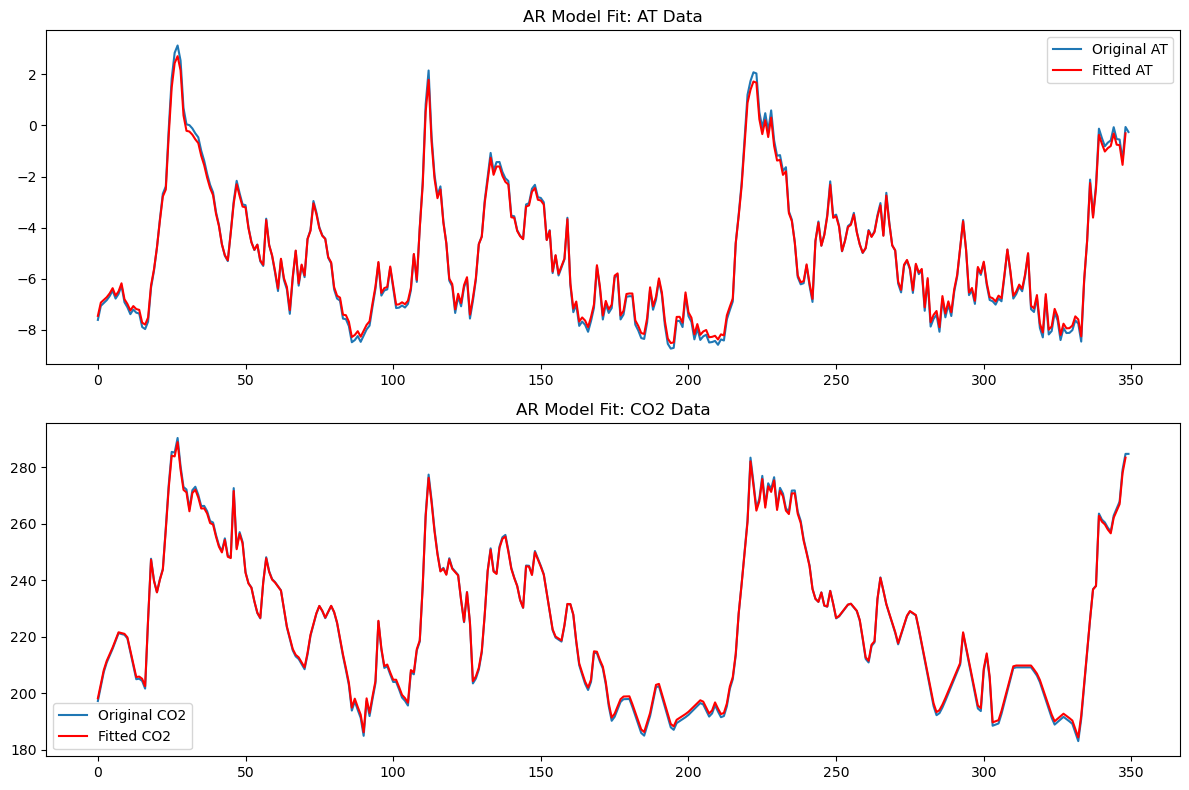

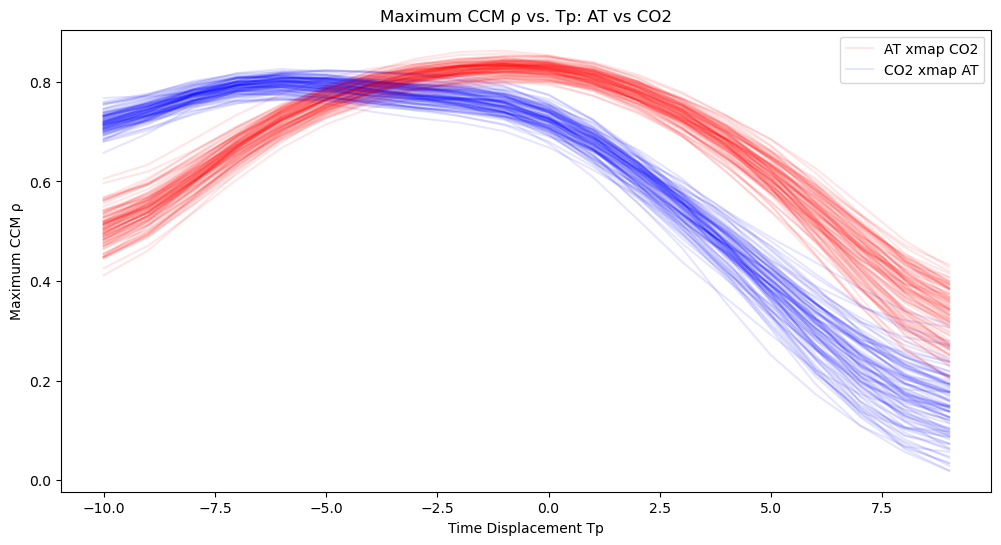

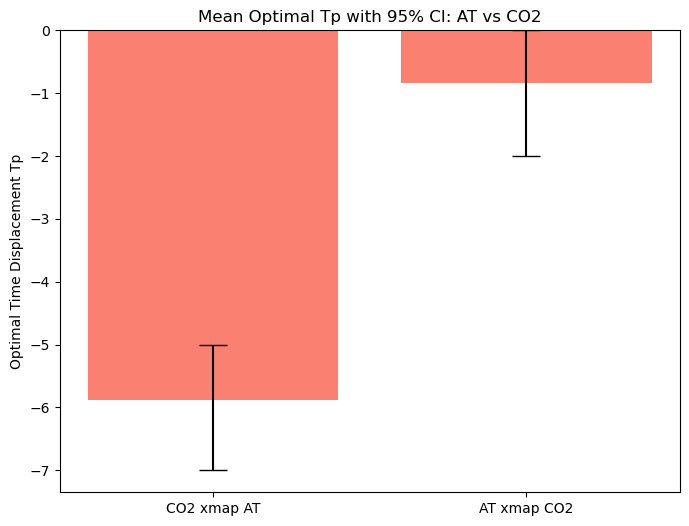

In [31]:

results = analyze_causality(
    var1_file=r"D:\VScode\van2015_repeat\VOSTOK_data\AT.csv",
    var1_col='AT',
    var2_file=r"D:\VScode\van2015_repeat\VOSTOK_data\CO2.csv",
    var2_col='CO2',
    var1_name='AT',
    var2_name='CO2',
    N_boots=100,
)



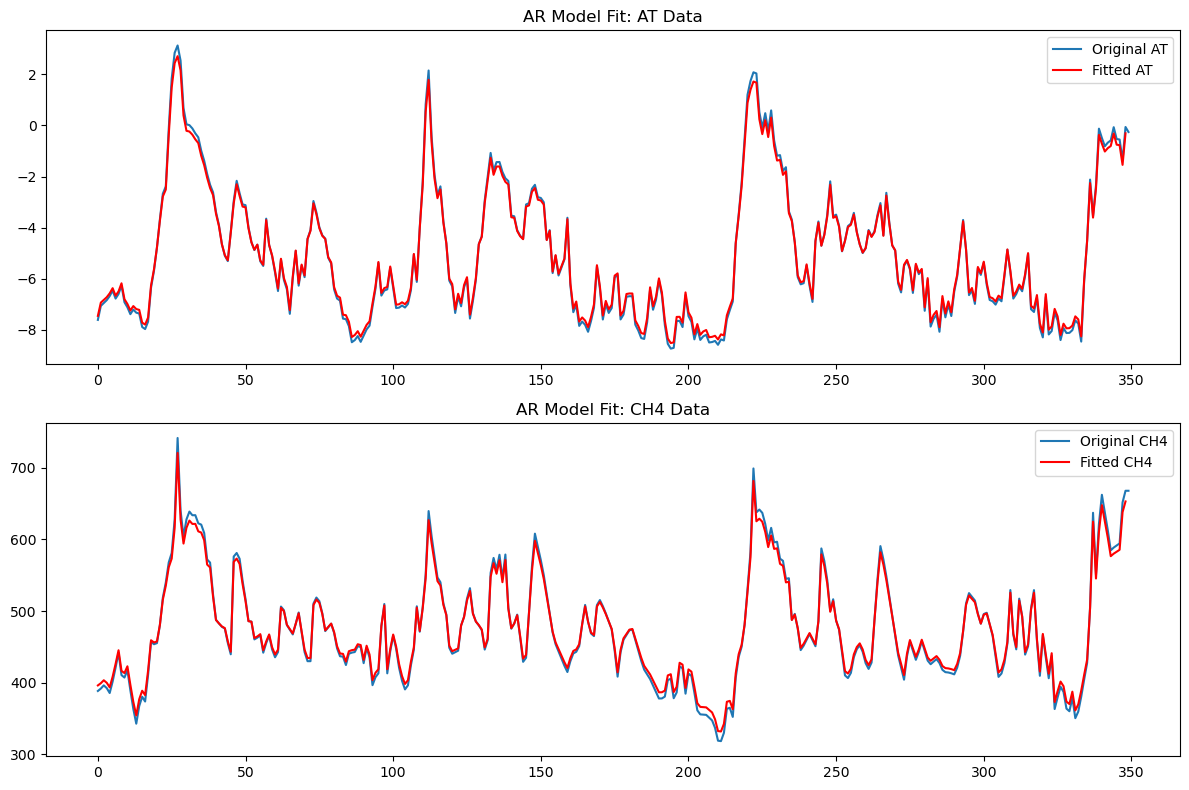

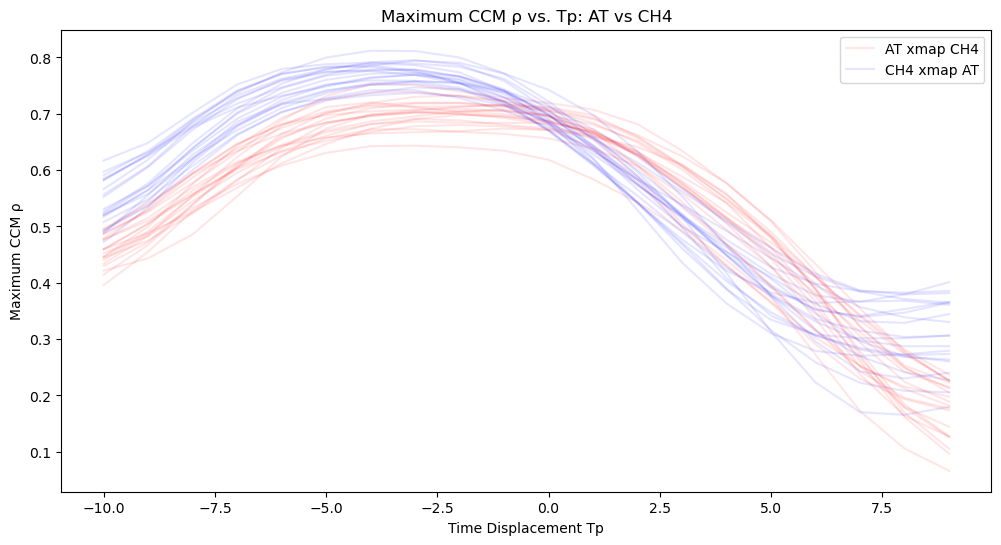

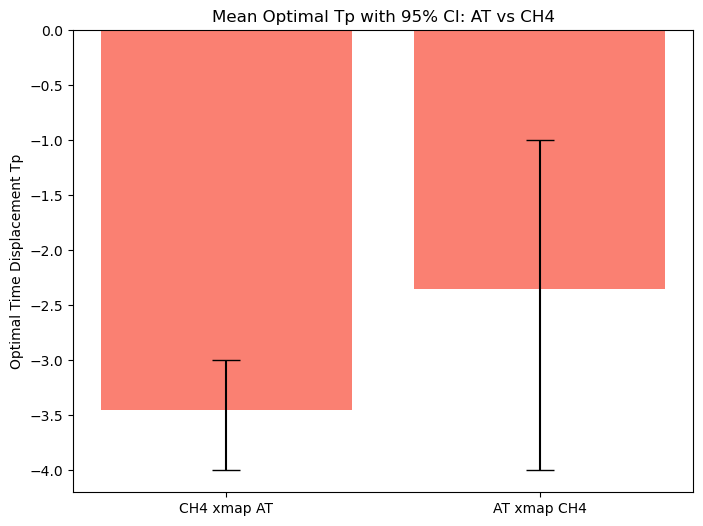

In [32]:
# For CH4 analysis
results_ch4 = analyze_causality(
    var1_file=r"D:\VScode\van2015_repeat\VOSTOK_data\AT.csv",
    var1_col='AT',
    var2_file=r"D:\VScode\van2015_repeat\VOSTOK_data\CH4.csv",
    var2_col='CH4',
    var1_name='AT',
    var2_name='CH4',
    N_boots=20,
)

In [8]:
AT_boot

(array([[-4.41196723, -4.97395632, -5.37109054, ..., -5.47304521,
         -6.4487097 , -4.7356753 ],
        [-5.13216639, -2.9737403 , -4.72069853, ..., -5.77049326,
         -3.53233612, -5.90757411],
        [-6.40001681, -3.2722464 , -4.63861996, ..., -4.79845439,
         -4.64156224, -4.40716118],
        ...,
        [-4.95287423, -5.24969007, -5.3218252 , ..., -5.65049106,
         -5.21295164, -5.88967349],
        [-2.70238917, -3.88055273, -3.53233612, ..., -4.14449871,
         -5.14170989, -4.2309514 ],
        [-4.11583707, -4.99259565, -6.21434867, ..., -4.80839328,
         -6.33904363, -6.74674796]]),
 {'nboot': 10,
  'data': array([-7.61027372, -7.06155598, -6.94746124, -6.83749507, -6.67849398,
         -6.46411885, -6.77567677, -6.59731959, -6.26254777, -6.91854251,
         -7.11678279, -7.38684211, -7.20413088, -7.32797131, -7.3608642 ,
         -7.888     , -7.97026052, -7.67875519, -6.35214123, -5.68446043,
         -4.78490956, -3.67617564, -2.67035928, -2.385

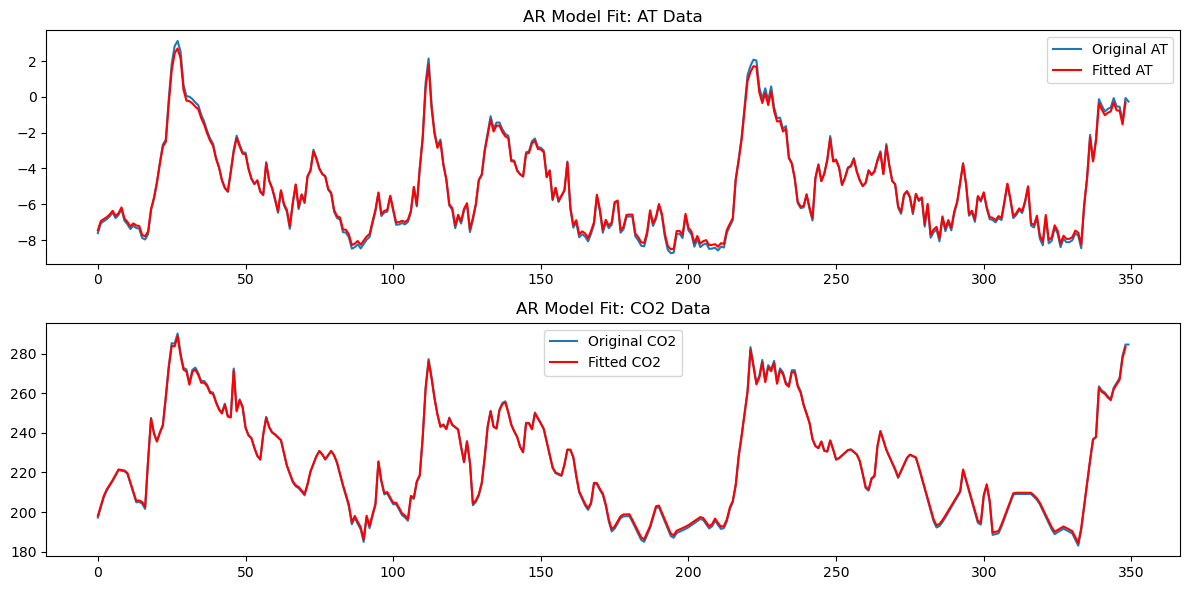

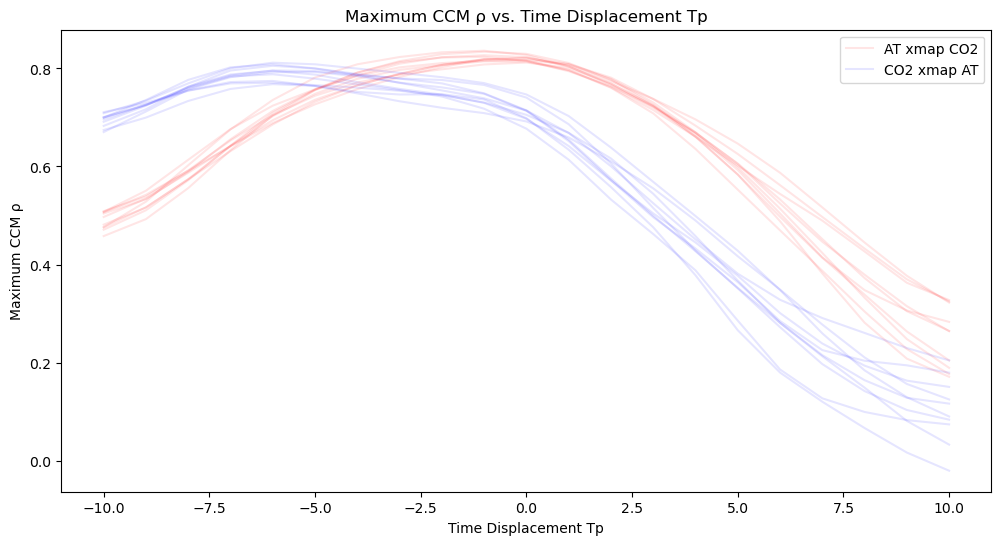

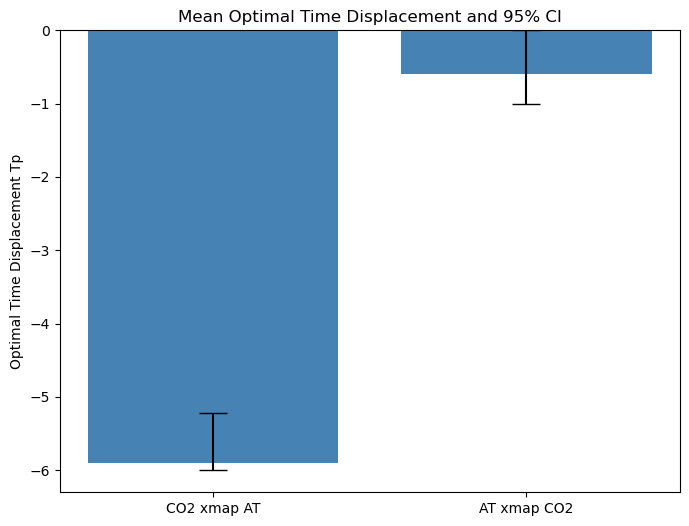

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from scipy.ndimage import gaussian_filter1d
from statsmodels.tsa.stattools import acf
from pyEDM import CCM
from scipy.stats import norm, percentileofscore

df_AT = pd.read_csv(r"D:\VScode\van2015_repeat\VOSTOK_data\AT.csv")
df_CO2 = pd.read_csv(r"D:\VScode\van2015_repeat\VOSTOK_data\CO2.csv")
AT = df_AT['AT'].values[49:] 
CO2 = df_CO2['CO2'].values[49:] 

# Fit AR models function
def fit_ar_model(series, p):
    model = AutoReg(series, lags=p, old_names=False)
    results = model.fit()
    return results.predict(start=p, end=len(series)-1)

# Fit and plot AR models
p = 1
fittedAT = fit_ar_model(AT, p)
fittedCO2 = fit_ar_model(CO2, p)

# Plot results
plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.plot(AT, label='Original AT')
plt.plot(fittedAT, 'r', label='Fitted AT')
plt.title('AR Model Fit: AT Data')
plt.legend()

plt.subplot(212)
plt.plot(CO2, label='Original CO2')
plt.plot(fittedCO2, 'r', label='Fitted CO2')
plt.title('AR Model Fit: CO2 Data')
plt.legend()
plt.tight_layout()

# Generate bootstrap samples
N_boots = 10

AT_boot, _ = sievebootstrap_res(AT, N_boots)  # Get just the bootstrap samples array
CO2_boot, _ = sievebootstrap_res(CO2, N_boots)

# Add fitted values to bootstrap samples
AT_boot = AT_boot[p:,:]  # Remove first p rows
CO2_boot = CO2_boot[p:,:]

# Now the addition will work
AT_boot += fittedAT[:, None]
CO2_boot += fittedCO2[:, None]

# CCM analysis parameters
E = 4
tau = -2
Tp_values = np.arange(-10, 11)
n = len(AT_boot)
time = np.arange(1, n + 1)

# Initialize result matrices
max_rho_ATxmapCO2_all = np.zeros((len(Tp_values), N_boots))
max_rho_CO2xmapAT_all = np.zeros_like(max_rho_ATxmapCO2_all)
Tp_ATxmapCO2 = np.zeros(N_boots)
Tp_CO2xmapAT = np.zeros(N_boots)

# Main analysis loop
for j in range(N_boots):
    rho_AT = np.zeros(len(Tp_values))
    rho_CO2 = np.zeros(len(Tp_values))
    
    for i, Tp in enumerate(Tp_values):
        # # AT xmap CO2
        # if Tp >= 0:
        #     idx = slice(None, n-Tp)
        #     shifted_AT = AT_boot[idx, j]
        #     cropped_CO2 = CO2_boot[idx+Tp, j]
        # else:
        #     idx = slice(-Tp, None)
        #     shifted_AT = AT_boot[idx, j]
        #     cropped_CO2 = CO2_boot[idx+Tp, j]
        
        # # Run CCM analysis
        # ccm_result = ccm(pd.DataFrame({'X': shifted_AT, 'Y': cropped_CO2}), 
        #                 E=E, libColumn='X', targetColumn='Y', libSizes=100, 
        #                 tau=tau, sample=100)

        df = pd.DataFrame({
            "Time": time,
            "AT": AT_boot[:, j],
            "CO2": CO2_boot[:, j]
        })
        ccm_out=CCM(
        dataFrame   = df,
        E           = 4,
        tau         = -2,
        columns     = 'AT',    # use X as the library (predictor)
        target      = 'CO2',    # predict Y (target)
        libSizes    = '100',
        sample      = 100,
        random      = False,
        replacement = False,
        Tp          = Tp
    )
        rho_AT[i] = ccm_out['AT:CO2'].max()
        
        # # CO2 xmap AT
        # if Tp >= 0:
        #     shifted_CO2 = CO2_boot[idx, j]
        #     cropped_AT = AT_boot[idx+Tp, j]
        # else:
        #     shifted_CO2 = CO2_boot[idx, j]
        #     cropped_AT = AT_boot[idx+Tp, j]
            
        # ccm_result = ccm(pd.DataFrame({'X': shifted_CO2, 'Y': cropped_AT}), 
        #                 E=E, libColumn='X', targetColumn='Y', libSizes=100, 
        #                 tau=tau, sample=100)
        rho_CO2[i] = ccm_out['CO2:AT'].max()
    
    # Smooth results
    smoothed_AT = gaussian_filter1d(rho_AT, sigma=1)
    smoothed_CO2 = gaussian_filter1d(rho_CO2, sigma=1)
    
    # Store results
    max_rho_ATxmapCO2_all[:, j] = smoothed_AT
    max_rho_CO2xmapAT_all[:, j] = smoothed_CO2
    Tp_ATxmapCO2[j] = Tp_values[np.argmax(smoothed_AT)]
    Tp_CO2xmapAT[j] = Tp_values[np.argmax(smoothed_CO2)]

# Plot results
plt.figure(figsize=(12, 6))
for j in range(N_boots):
    plt.plot(Tp_values, max_rho_ATxmapCO2_all[:, j], 'r', alpha=0.1)
    plt.plot(Tp_values, max_rho_CO2xmapAT_all[:, j], 'b', alpha=0.1)
plt.xlabel('Time Displacement Tp')
plt.ylabel('Maximum CCM ρ')
plt.title('Maximum CCM ρ vs. Time Displacement Tp')
plt.legend(['AT xmap CO2', 'CO2 xmap AT'])

# Calculate statistics
mean_Tp_AT = np.mean(Tp_ATxmapCO2)
mean_Tp_CO2 = np.mean(Tp_CO2xmapAT)
ci_AT = np.percentile(Tp_ATxmapCO2, [2.5, 97.5])
ci_CO2 = np.percentile(Tp_CO2xmapAT, [2.5, 97.5])

# Final bar plot
plt.figure(figsize=(8, 6))
labels = ['CO2 xmap AT', 'AT xmap CO2']
means = [mean_Tp_CO2, mean_Tp_AT]
cis = [(mean_Tp_CO2 - ci_CO2[0], ci_CO2[1] - mean_Tp_CO2),
       (mean_Tp_AT - ci_AT[0], ci_AT[1] - mean_Tp_AT)]

plt.bar([0, 1], means, yerr=np.array(cis).T, 
        capsize=10, color=['steelblue', 'steelblue'])
plt.xticks([0, 1], labels)
plt.ylabel('Optimal Time Displacement Tp')
plt.title('Mean Optimal Time Displacement and 95% CI')
plt.show()